## Pre-processing of Images before Registration

In [1]:
import os
from os import listdir, mkdir
from os.path import isdir, join
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.exposure import histogram
from skimage import exposure

In [6]:
# Remove skull from MNI template image
from nibabel.funcs import four_to_three

mni_atlas_folder = './data/MNITemplateAtlas/'
mni_atlas_path = 'atlas.nii.gz'
mni_template_path = 'template.nii.gz'

mni_atlas = nib.load(join(mni_atlas_folder, mni_atlas_path))
# 1st - Mask, 2nd - CSF, 3rd - GM, 4th - WM
ext = '.nii.gz'
names = ['Mask', 'CSF_probs', 'GM_probs', 'WM_probs']

# Apply mask to MNI template and save
mni_template = nib.load(join(mni_atlas_folder, mni_template_path))
template_data = mni_template.get_data()

imgs = four_to_three(mni_atlas)
mask_img = imgs[0]
mask_data = 1 - mask_img.get_data()
masked_img = nib.Nifti1Image(mask_data, mni_template.affine, mni_template.header)
nib.save(masked_img, join(mni_atlas_folder, 'Mask' + ext))

masked_template_data = mask_data * template_data
masked_template_data = masked_template_data.astype(int)
masked_template_img = nib.Nifti1Image(masked_template_data, mni_template.affine, mni_template.header)
nib.save(masked_template_img, join(mni_atlas_folder, 'masked_template' + ext))
print(np.max(masked_template_data))

8363


In [7]:
%run "./src/nib-tools.py"

In [10]:
# Normalize the MNI atlas
mni_atlas_folder = './data/MNITemplateAtlas/'
mni_template_path = 'masked_template.nii.gz'
result_folder = "./data/MNITemplateAtlas-norm"

# Read nii from path and normalize array from 0 to 255
temp_data, temp_img = read_im(join(mni_atlas_folder, mni_template_path))
temp_data = normalize(temp_data).astype(int)
template_img = nib.Nifti1Image(temp_data, temp_img.affine, temp_img.header)
nib.save(template_img, join(result_folder, mni_template_path))

In [3]:
def hist_stretch(data, cutoff_percent, nbins=256):
    """
    Contrast stretching.
    
    Parameters:
        data (numpy.ndarray): an input image or a 3D scan.
    """
    hist1, _ = histogram(data, nbins=nbins)
    cdf1 = np.cumsum(hist1) / np.cumsum(hist1)[-1]
    #print(cdf1)
    p99 = np.argwhere(cdf1>cutoff_percent)
    cutoff_val = p99[0]
    #print(cutoff_val)
    data[data > cutoff_val] = cutoff_val
    data_rescale = data
    data_rescale = normalize(data).astype(int)
    return data_rescale


# Function to pre-process data using histogram matching
def hist_match(target_data, base_data, nbins=256):
    """Function to pre-process data using histogram matching
        Input: data(np.array): data to be pre-processed"""
    from skimage.exposure import histogram
    M = np.zeros((nbins,1))
    hist1, _ = histogram(target_data, nbins=nbins)
    hist2, hist2_bins = histogram(base_data, nbins=nbins)
    
    cdf1 = np.cumsum(hist1) / np.cumsum(hist1)[-1]
    cdf2 = np.cumsum(hist2) / np.cumsum(hist2)[-1]
#     plt.plot(range(1, nbins), hist1[1:])
#     plt.title("Hist 1")
#     plt.show()
    
#     plt.plot(hist2_bins[1:], hist2[1:])
#     plt.title("Hist 2")
#     plt.show()
    
    # Compute the mapping
    for i in range(0, nbins):
        ind = np.argmin(np.abs(cdf1[i] - cdf2))
        M[i] = ind

#     plt.plot(range(0, nbins), M)
#     plt.title("Hist M")
#     plt.show()
    
#     print(M)
#     print(M.max(), M.min())
    #print()
    hist_mapped_data = M[target_data.astype(int)]
    
    return hist_mapped_data

In [140]:
# function to check our histogram matching, from another source
def test_hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [22]:
data_folder_name = "Validation_Set"
data_dir = f"./data/{data_folder_name}/"
onlydirs = [f for f in listdir(data_dir) if isdir(join(data_dir, f))]

In [23]:
# Path to result folder
result = f"./pre-processed-data/hist-stretched/{data_folder_name}/"
os.mkdir(result)

IBSR_10, (256, 128, 256, 1), (1.0, 1.5, 1.0, 0.0)
IBSR_02, (256, 128, 256, 1), (0.9375, 1.5, 0.9375, 0.0)
IBSR_15, (256, 128, 256, 1), (0.8370536, 1.5, 0.8370536, 0.0)


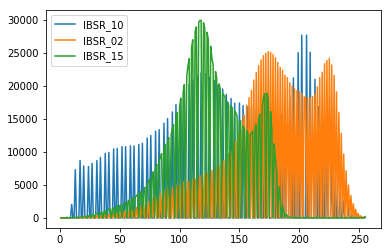

In [17]:
for f in onlydirs:
    # Import image to be processed
    img_path = join(data_dir,f,f'{f}.nii.gz')
    img = nib.load(img_path)
    data = img.get_data()
    
    print(f"{f}, {data.shape}, {img.header.get_zooms()}")
    
    # Pre-process image data
    nbins = 256
    data = hist_stretch(data, 0.99999, nbins=nbins)
    hist, hist_bins = histogram(data, nbins=nbins)
    
    stretched_img = nib.Nifti1Image(data, img.affine, img.header)
    nib.save(stretched_img, join(result,f"{f}.nii.gz"))
    
    plt.plot(hist_bins[1:], hist[1:])

plt.legend(onlydirs)
plt.show()

IBSR_18, (182, 218, 182), (1.0, 1.0, 1.0)
IBSR_03, (182, 218, 182), (1.0, 1.0, 1.0)
IBSR_01, (182, 218, 182), (1.0, 1.0, 1.0)
IBSR_06, (182, 218, 182), (1.0, 1.0, 1.0)
IBSR_09, (182, 218, 182), (1.0, 1.0, 1.0)
IBSR_07, (182, 218, 182), (1.0, 1.0, 1.0)
IBSR_16, (182, 218, 182), (1.0, 1.0, 1.0)
IBSR_08, (182, 218, 182), (1.0, 1.0, 1.0)
IBSR_05, (182, 218, 182), (1.0, 1.0, 1.0)
IBSR_04, (182, 218, 182), (1.0, 1.0, 1.0)


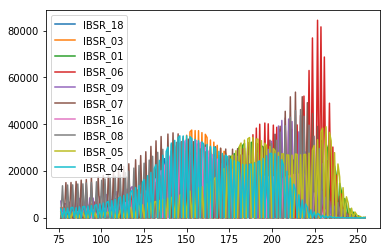

In [132]:
registered_data_dir = "./registered-data/Training_Set/templates"

for f in onlydirs:
    # Import image to be processed
    img_path = join(registered_data_dir,f,'result.1.nii.gz')
    img = nib.load(img_path)
    data = img.get_data()
    data = normalize(data)
    
    print(f"{f}, {data.shape}, {img.header.get_zooms()}")
    
    # Pre-process image data
    nbins = 256
    data = hist_stretch(data, 0.99999, nbins=nbins)
    hist, hist_bins = histogram(data, nbins=nbins)
    
    # removes background bins
    plt.plot(hist_bins[76:], hist[76:])

plt.legend(onlydirs)
plt.show()

In [133]:
# Perform histogram matching before registration
M = np.zeros((256,1))

In [134]:
img_path = join(data_dir,f,f'{f}.nii.gz')
img = nib.load(img_path)
data = img.get_data()
#data = hist_stretch(data, 0.99999, nbins=256)
print(data.shape)

reg_img_path = join(registered_data_dir, f, 'result.1.nii.gz')
reg_img = nib.load(reg_img_path)
reg_data = reg_img.get_data()
reg_data = hist_stretch(reg_data, 0.99, nbins=256)

print(reg_data.shape)

(256, 128, 256, 1)
(182, 218, 182)


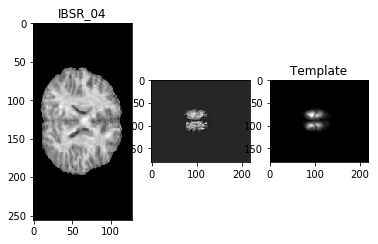

In [135]:
plt.subplot('131')
plt.imshow(data[:,:,150, 0], cmap = "gray")
plt.title(f)

plt.subplot('132')
plt.imshow(reg_data[:,:,150], cmap = "gray")

plt.subplot('133')
plt.imshow(temp_data[:,:,150], cmap = "gray")
plt.title("Template")
plt.show()

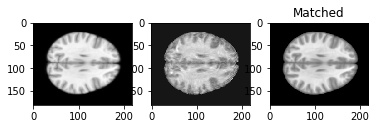

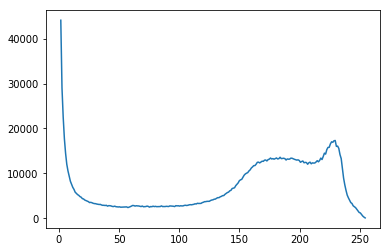

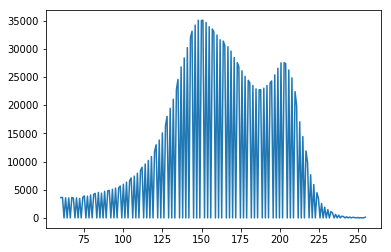

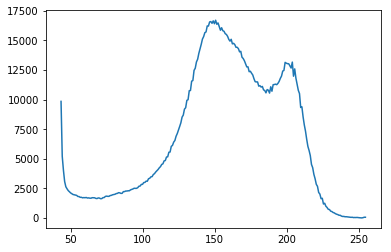

In [150]:
#hist_matched_data = hist_match(temp_data, reg_data, nbins=256)
hist_matched_data = test_hist_match(temp_data, reg_data)

hist1, hist_bins1 = histogram(temp_data, nbins=nbins)
hist2, hist_bins2 = histogram(reg_data, nbins=nbins)
histm, hist_binsm = histogram(hist_matched_data, nbins=nbins)

plt.subplot('131')
plt.imshow(temp_data[:,:,100], cmap = "gray")
#plt.title('IBSR_04')

plt.subplot('132')
plt.imshow(reg_data[:,:,100], cmap = "gray")
#plt.title('IBSR_05')

plt.subplot('133')
plt.imshow(hist_matched_data[:,:,100], cmap = "gray")
plt.title("Matched")
plt.show()


plt.plot(hist_bins1[1:], hist1[1:])
plt.show()
plt.plot(hist_bins2[60:], hist2[60:])
plt.show()
plt.plot(hist_binsm[1:], histm[1:])
#plt.legend(('1', '2', 'm'))
plt.show()

## Matching on Non-registered Data

In [144]:
f = 'IBSR_04'
img_path1 = join(data_dir,f,f'{f}.nii.gz')
img1 = nib.load(img_path1)
data1 = img1.get_data()
data1 = normalize(data1)

f = 'IBSR_16'
img_path2 = join(data_dir,f,f'{f}.nii.gz')
img2 = nib.load(img_path2)
data2 = img2.get_data()
data2 = normalize(data2)

hist_matched_data = hist_match(data1, data2, nbins=256)

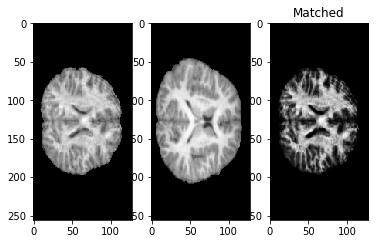

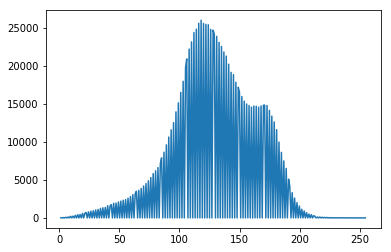

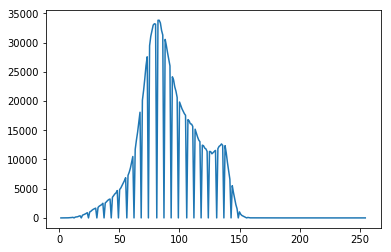

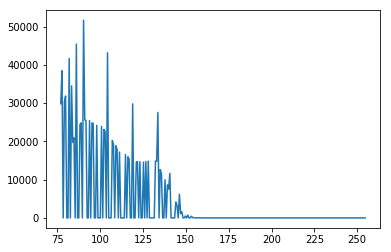

In [145]:
plt.subplot('131')
plt.imshow(data1[:,:,150, 0], cmap = "gray")
#plt.title('IBSR_04')

plt.subplot('132')
plt.imshow(data2[:,:,150, 0], cmap = "gray")
#plt.title('IBSR_05')

plt.subplot('133')
plt.imshow(hist_matched_data[:,:,150, 0, 0], cmap = "gray")
plt.title("Matched")
plt.show()

hist1, hist_bins1 = histogram(data1, nbins=nbins)
hist2, hist_bins2 = histogram(data2, nbins=nbins)
histm, hist_binsm = histogram(hist_matched_data, nbins=nbins)

plt.plot(hist_bins1[1:], hist1[1:])
plt.show()
plt.plot(hist_bins2[1:], hist2[1:])
plt.show()
plt.plot(hist_binsm[1:], histm[1:])
#plt.legend(('1', '2', 'm'))
plt.show()

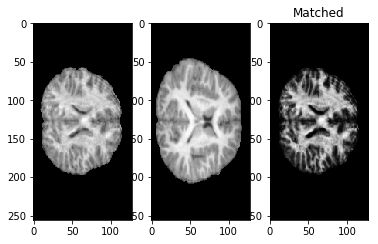

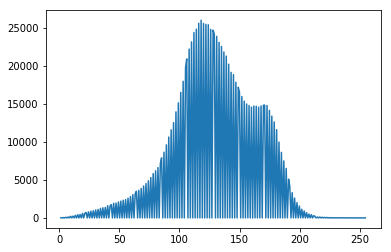

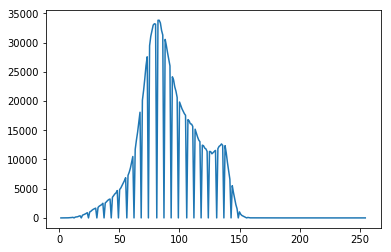

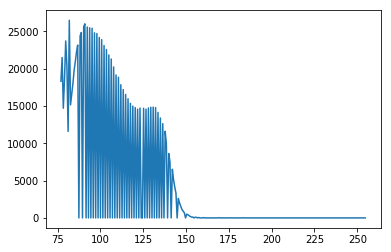

In [146]:
hist_matched_data = test_hist_match(data1, data2)

plt.subplot('131')
plt.imshow(data1[:,:,150, 0], cmap = "gray")
#plt.title('IBSR_04')

plt.subplot('132')
plt.imshow(data2[:,:,150, 0], cmap = "gray")
#plt.title('IBSR_05')

plt.subplot('133')
plt.imshow(hist_matched_data[:,:,150, 0], cmap = "gray")
plt.title("Matched")
plt.show()

hist1, hist_bins1 = histogram(data1, nbins=nbins)
hist2, hist_bins2 = histogram(data2, nbins=nbins)
histm, hist_binsm = histogram(hist_matched_data, nbins=nbins)

plt.plot(hist_bins1[1:], hist1[1:])
plt.show()
plt.plot(hist_bins2[1:], hist2[1:])
plt.show()
plt.plot(hist_binsm[1:], histm[1:])
#plt.legend(('1', '2', 'm'))
plt.show()

## Generate Bash Commands to Perform Registration 

In [8]:
# Write commands for elastix test set registration
# Add parameter folder name and paramter file names (must be saved in ./parameter-files folder)
which_set = 'Test_Set' # folder name where results will be saved
param_1 = './parameter-files/par0009.affine-hist256.txt'
param_2 = './parameter-files/par0009.bspline-hist256.txt'
data_dir = f"./pre-processed-data/matched-to-mni/{which_set}/"
labels_dir = f"./data/{which_set}/"
test_ims = [f for f in listdir(data_dir) if f.endswith(".nii.gz")]
result_folder = f"./registered-data/Par0009-matched-to-mni-256hist/{which_set}/"
mkdir(result_folder)
mkdir(os.path.join(result_folder,"templates"))
mkdir(os.path.join(result_folder,"labels"))

In [9]:
# Section writes to file in src folder
fixed_im_path = './data/MNITemplateAtlas-norm/masked_template.nii.gz'

with open(f"elastix_{which_set}", 'w+') as out_f:
    
    for chosen_im in test_ims:
        moving_im_path = os.path.join(data_dir, chosen_im)
        result_path = os.path.join(result_folder, "templates", chosen_im[:-7])
        param_1_path = param_1
        param_2_path = param_2    
        mkdir(result_path)
        cmd = f"elastix -f {fixed_im_path} -m {moving_im_path} -out {result_path} -p {param_1_path} -p {param_2_path}\n"
        out_f.write(cmd)



In [10]:
with open(f"transformix_{which_set}", 'w+') as out_f:
    for chosen_im in test_ims:
        labels_path = os.path.join(labels_dir, f'{chosen_im[:-7]}/{chosen_im[:-7]}_seg.nii.gz')
        result_path = os.path.join(result_folder, f"labels/{chosen_im[:-7]}")
        mkdir(result_path)
        parameters_path = os.path.join(result_folder, f"templates/{chosen_im[:-7]}/TransformParameters.1.txt")
        cmd = f"transformix -in {labels_path} -out {result_path} -tp {parameters_path}\n"
        out_f.write(cmd)

In [189]:
result_folder = "./registered-data/Training_Set/"
#Change line "(FinalBSplineInterpolationOrder 3)" in Transform parameters files
bad_files = []

for chosen_im in test_ims:
    try:
        parameters0_path = os.path.join(result_folder, "templates", f"{chosen_im}/TransformParameters.0.txt")
        parameters1_path = os.path.join(result_folder, "templates", f"{chosen_im}/TransformParameters.1.txt")
        
        replace(parameters0_path,"(FinalBSplineInterpolationOrder 3)","(FinalBSplineInterpolationOrder 0)")
        #replace(parameters0_path, '(ResultImagePixelType "short")', '(ResultImagePixelType "float")')
        #replace(parameters0_path, '(ResultImageFormat "nii")', '(ResultImageFormat "nii.gz")')
        
        replace(parameters1_path,"(FinalBSplineInterpolationOrder 3)","(FinalBSplineInterpolationOrder 0)")
        #replace(parameters1_path, '(ResultImagePixelType "short")', '(ResultImagePixelType "float")')
        #replace(parameters1_path, '(ResultImageFormat "nii")', '(ResultImageFormat "nii.gz")')
        
    except IOError as e:
        print(e)
        bad_files.append(f)

print(bad_files)

[]
